In [2]:
#ta imports poy xreiazontai gia to project
import pandas as pd 
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import warnings

In [3]:
#diabazw to csv kai to bazw se ena df
df = pd.read_csv('IMDB_Dataset.csv', encoding='latin-1', on_bad_lines='skip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
#testarw na dw ean uparxei kapoio review xwris sentiment
df[~df['sentiment'].isin(['positive', 'negative'])]


,review,sentiment


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Text(0.5, 1.0, 'Distribution of Positive / Negative Emotions')

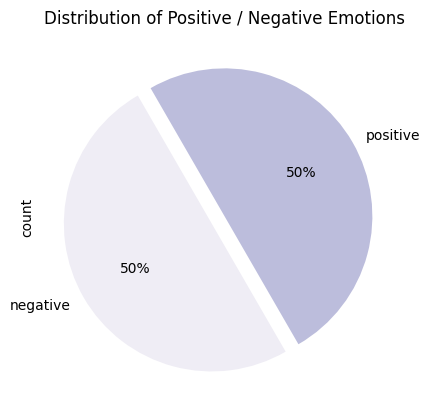

In [8]:
#plottarw ta sentiments se pie gia na dw ean einai zugismeno to dataset
df['sentiment'].value_counts().plot.pie(explode=[0,0.1], autopct='%2.0f%%', startangle=300, colors = ["#bcbddc", "#efedf5"])
plt.title("Distribution of Positive / Negative Emotions")

In [9]:
df.groupby(['sentiment'])[['sentiment']].count()

,sentiment
sentiment,
negative,25000
positive,25000


In [11]:
#aplo function gia na metraei tis lekseis se kathe review
def no_of_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [12]:
#to prosthetw sto df
df['word_count'] = df['review'].apply(no_of_words)

In [13]:
df.head(10)

,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230
5,"Probably my all-time favorite movie, a story o...",positive,119
6,I sure would like to see a resurrection of a u...,positive,150
7,"This show was an amazing, fresh & innovative i...",negative,174
8,Encouraged by the positive comments about this...,negative,130
9,If you like original gut wrenching laughter yo...,positive,33


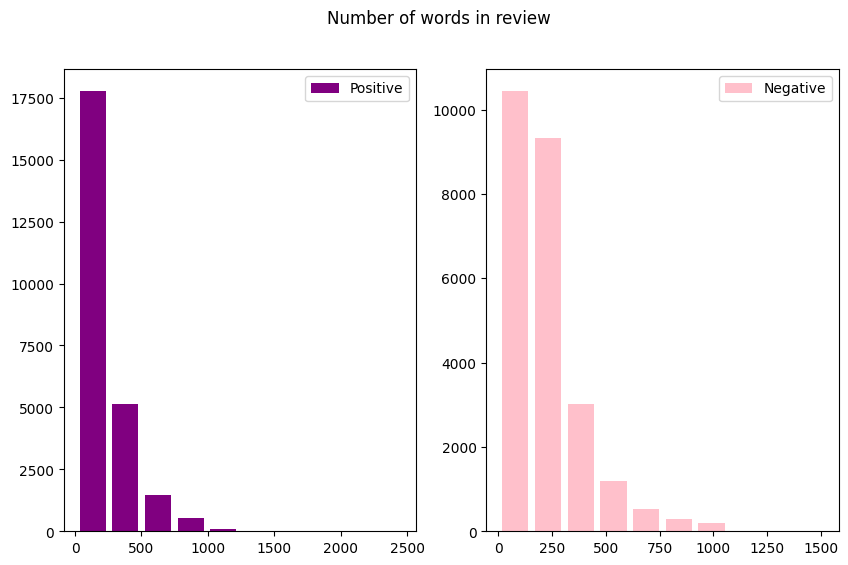

In [14]:
#plottarw ton arithmo leksewn analoga to sentiment
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['word_count'], label='Positive', color='purple', rwidth=0.8);
ax[1].hist(df[df['sentiment'] == 'negative']['word_count'], label='Negative', color='pink', rwidth=0.8);

ax[0].legend(loc='upper right');
ax[1].legend(loc='upper right');

fig.suptitle("Number of words in review")
plt.show()

In [15]:
#allazw to sentiment apo text se boolean kathws etsi ekpaideuontai kalytera ta montela
df.sentiment.replace("positive", 1, inplace=True)
df.sentiment.replace("negative", 0, inplace=True)

C:\Users\Ryzen\AppData\Local\Temp\ipykernel_20704\2333724438.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.sentiment.replace("positive", 1, inplace=True)
C:\Users\Ryzen\AppData\Local\Temp\ipykernel_20704\2333724438.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [16]:
df.head()

,review,sentiment,word_count
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


In [18]:
#xrisimopoiw to nltk gia na kataibasw stopwords kai punkt ta opoia tha xrhsimopoihsw sto preprocessing tou text
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryzen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryzen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Ryzen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [19]:

stop_words = set(stopwords.words('english'))

def process(review):
    # koitaw prwta ama sto text uparxoyn html tags
    if re.search('<.*?>', review):  
        review = BeautifulSoup(review, 'html.parser').get_text()  # ean uparxoun kanw parse me beatifulSoup
    review = review.lower() #kanw to text se lower
    review = re.sub("[^a-zA-Z]",' ',review)#afairw ola ta mh grammata
    review = re.sub(r"https\S+|www\S+|http\S+", '', review, flags = re.MULTILINE)#afairei ta urls
    review = re.sub(r'\@w+|\#', '', review)#afairei ola ta usernames h tags
    review = re.sub(r'[^\w\s]', '', review)#afairei to punctuation
    review_tokens = word_tokenize(review)#kanw tokenization
    filtered_review = [w for w in review_tokens if not w in stop_words]# psaxnei gia common stopwords kai ta afairei kathws den xreiazontai
    return " ".join(filtered_review) # telos ta filtrarizmena tokens gurnane se ena string

In [20]:
#kanw process se ola ta reviews
df.review = df['review'].apply(process)

In [23]:
#dropparw ola ta duplicates
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)
df = df.drop_duplicates('review')

Number of duplicate entries:  0


In [24]:
#xrhsimopoiw stemming gia na ferw tis lekseis sthn pio aplh tous morfh kathws etsi tha kanoyn pio eykola train ta montela
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return ''.join(text)

In [25]:
#kanw apply to stemming
df.review = df['review'].apply(lambda x: stemming(x))

In [26]:
print(df.review)

0        one reviewers mentioned watching oz episode ho...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movies high art fans exp...
Name: review, Length: 49575, dtype: object


In [27]:
#parathrw oti meta to preprocess oi lekseis meiwthhkan shmantika kanwntas etsi to training pio grhgoro sta montela xwris na epireazei to accuracy tous
df['new_word_count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word_count,new_word_count
0,one reviewers mentioned watching oz episode ho...,1,307,162
1,wonderful little production filming technique ...,1,162,86
2,thought wonderful way spend time hot summer we...,1,166,84
3,basically family little boy jake thinks zombie...,0,138,64
4,petter mattei love time money visually stunnin...,1,230,125


In [28]:
pos_reviews =  df[df.sentiment == 1]
pos_reviews.head()

,review,sentiment,word_count,new_word_count
0,one reviewers mentioned watching oz episode ho...,1,307,162
1,wonderful little production filming technique ...,1,162,86
2,thought wonderful way spend time hot summer we...,1,166,84
4,petter mattei love time money visually stunnin...,1,230,125
5,probably time favorite movie story selflessnes...,1,119,54


In [29]:
neg_reviews =  df[df.sentiment == 0]
neg_reviews.head()

,review,sentiment,word_count,new_word_count
3,basically family little boy jake thinks zombie...,0,138,64
7,show amazing fresh innovative idea first aired...,0,174,78
8,encouraged positive comments film looking forw...,0,130,62
10,phil alien one quirky films humour based aroun...,0,96,50
11,saw movie came recall scariest scene big bird ...,0,180,82


In [30]:
#splittarw to data se 2 df's opoy to X apoteleite apo ta reviews kai to Y apo ta sentiments
X = df['review']
Y = df['sentiment']

In [31]:
X

0        one reviewers mentioned watching oz episode ho...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movies high art fans exp...
Name: review, Length: 49575, dtype: object

In [32]:
Y

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 49575, dtype: int64

In [33]:
#xrhsimopoiw to TfidfVectorizer gia na kanw vectorize ta reviews 
vect = TfidfVectorizer()
X = vect.fit_transform(df['review'])

In [69]:
#splittarw to data se train kai test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [70]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (34702, 101201)
Size of y_train:  (34702,)
Size of x_test:  (14873, 101201)
Size of y_test:  (14873,)


In [74]:
#xrhsimopoiw to sklearn gia na fittarw to linearSVC montelo
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
svc = LinearSVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy: {:.2f}%".format(svc_acc*100))

Test accuracy: 89.42%


In [75]:
#printarw tis pio common metrikes
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[6570  849]
 [ 724 6730]]


              precision    recall  f1-score   support

           0       0.90      0.89      0.89      7419
           1       0.89      0.90      0.90      7454

    accuracy                           0.89     14873
   macro avg       0.89      0.89      0.89     14873
weighted avg       0.89      0.89      0.89     14873



In [76]:
#sunarthsh gia predict se custom review
def predict_sentiment(custom_review):
    # thn kanw preprocess
    processed_review = process(custom_review)
    
    # thn kanw vectorize me to fitted vectorizer 
    custom_review_vectorized = vect.transform([processed_review]) 
    
    # kanw prediction
    prediction = svc.predict(custom_review_vectorized)
    
    return prediction[0]

In [77]:
# testarw toi function
custom_review = "the movie was so good i liked it"
predicted_sentiment = predict_sentiment(custom_review)
print("Predicted sentiment:", predicted_sentiment)

Predicted sentiment: 1


In [82]:
from tensorflow import keras #kanw import keras giati thelw to sequential montelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping # xrhsimopoiw early stopping me bash to val_loss 
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model = Sequential([
    Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

# Σύνθεση του μοντέλου
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Εκπαίδευση του μοντέλου
model.fit(x_train, y_train, epochs=10, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

# Αξιολόγηση
loss, accuracy = model.evaluate(x_test, y_test)
print("Accuracy:", accuracy)

C:\Users\Ryzen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 166s 85ms/step - accuracy: 0.8213 - loss: 0.3991 - val_accuracy: 0.8995 - val_loss: 0.2484
Epoch 2/10
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 171s 88ms/step - accuracy: 0.9549 - loss: 0.1258 - val_accuracy: 0.8983 - val_loss: 0.2835
Epoch 3/10
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 169s 87ms/step - accuracy: 0.9814 - loss: 0.0576 - val_accuracy: 0.8954 - val_loss: 0.3616
Epoch 4/10
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 168s 86ms/step - accuracy: 0.9922 - loss: 0.0251 - val_accuracy: 0.8871 - val_loss: 0.5056
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8961 - loss: 0.2512
Accuracy: 0.8965238928794861


In [83]:

#sunarthsh gia predict se custom review se sequential model
def predict_sentiment(custom_review):
    # Preprocess the custom review
    processed_review = process(custom_review)
    
    # Vectorize the processed review using the same vectorizer
    custom_review_vectorized = vect.transform([processed_review])  # Use the same vectorizer
    
    # Make a prediction
    prediction = model.predict(custom_review_vectorized)
    
    return prediction[0]

In [100]:
# test gia custom review
import numpy as np
custom_review = "the movie was great"
predicted_sentiment = predict_sentiment(custom_review) 
certainty = predicted_sentiment[0] if isinstance(predicted_sentiment, np.ndarray) else predicted_sentiment
certainty = certainty if certainty > 0.5 else 1 - certainty

if predicted_sentiment > 0.5:
    print(f"Predicted sentiment was positive with {certainty * 100:.2f}% certainty")
else:
    print(f"Predicted sentiment was negative with {certainty * 100:.2f}% certainty")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted sentiment was positive with 99.86% certainty


In [98]:
# Print comparison of Linear SVC and Sequential Model
print("Comparison of Linear SVC and Sequential Model:")

# Linear SVC results
print("\nLinear SVC Results:")
print(f"Accuracy: {svc_acc:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, svc_pred))
print("\nClassification Report:")
print(classification_report(y_test, svc_pred))

# Sequential Model results
print("\nSequential Model Results:")
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
sequential_pred = (model.predict(x_test) > 0.5).astype(int)
print(confusion_matrix(y_test, sequential_pred))
print("\nClassification Report:")
print(classification_report(y_test, sequential_pred))

# Observations
print("\nObservations:")
print("- The Linear SVC model achieved an accuracy of {:.2f}%.".format(svc_acc * 100))
print("- The Sequential model achieved an accuracy of {:.2f}%.".format(accuracy * 100))
print("- Analyze precision, recall, and F1-score for each class to understand model performance.")
print("- Consider the confusion matrix to identify types of errors (false positives, false negatives).")
print("- Note that the Sequential model might take longer to train due to its complexity.")

Comparison of Linear SVC and Sequential Model:

Linear SVC Results:
Accuracy: 0.89
Confusion Matrix:
[[6570  849]
 [ 724 6730]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      7419
           1       0.89      0.90      0.90      7454

    accuracy                           0.89     14873
   macro avg       0.89      0.89      0.89     14873
weighted avg       0.89      0.89      0.89     14873


Sequential Model Results:
Accuracy: 0.90
Confusion Matrix:
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[[6450  969]
 [ 570 6884]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      7419
           1       0.88      0.92      0.90      7454

    accuracy                           0.90     14873
   macro avg       0.90      0.90      0.90     14873
weighted avg       0.90      0.90      0.90     14873


Observations:
- The Linear SVC model achi

In [99]:
#xrhsimopoiw joblib gia na kanw save ta montela wste na ta xrhsiompoihsw me flask
import joblib
joblib.dump(svc, 'svc_model.pkl')
joblib.dump(vect, 'vectorizer.pkl')
model.save('keras_model.h5')